In [ ]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry
import cv2

In [2]:
# Define our feature extraction hook
class EncoderFeatureExtractor:
    def __init__(self):
        self.features = None
    
    def hook(self, module, input, output):
        self.features = output

In [ ]:
# Load model the same way as in your tutorial
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
print("Model loaded successfully")

Model loaded successfully


In [4]:
# Get the image encoder and register the hook
image_encoder = medsam_model.image_encoder
feature_extractor = EncoderFeatureExtractor()
hook_handle = image_encoder.register_forward_hook(feature_extractor.hook)
print(f"Hook registered to {type(image_encoder).__name__}")

Hook registered to ImageEncoderViT


In [5]:
# Function to preprocess images the same way MedSAM does
def preprocess_image(img_path):
    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize image to fit SAM's requirements (optional but recommended)
    h, w = image.shape[:2]
    scale_factor = 1024 / max(h, w)
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    image = cv2.resize(image, (new_w, new_h))
    
    # Preprocess for SAM: normalize and convert to tensor
    pixel_mean = np.array([123.675, 116.28, 103.53])
    pixel_std = np.array([58.395, 57.12, 57.375])
    image = (image - pixel_mean) / pixel_std
    
    # HWC to CHW format and add batch dimension
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(device).float()
    return image, cv2.imread(img_path, cv2.IMREAD_COLOR)


Input shape: torch.Size([1, 3, 1024, 1024])
Extracted encoder feature shape: torch.Size([1, 256, 64, 64])


(-0.5, 511.5, 511.5, -0.5)

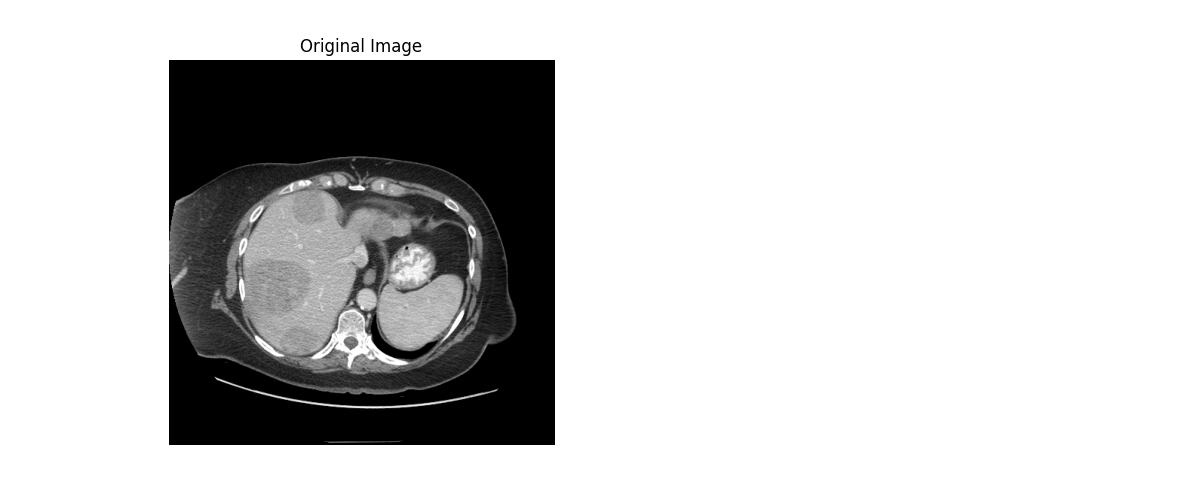

In [6]:
# Test with a medical image
test_image = "assets/img_demo.png"  # Use the demo image or your own image
preprocessed_img, original_img = preprocess_image(test_image)
print(f"Input shape: {preprocessed_img.shape}")

# Forward pass to trigger hook - DIRECTLY USE THE IMAGE ENCODER
with torch.no_grad():
    _ = medsam_model.image_encoder(preprocessed_img)

# Get features from the hook
encoder_features = feature_extractor.features
print(f"Extracted encoder feature shape: {encoder_features.shape}")

# Visualize original image and feature maps
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')


In [7]:
import os
import nibabel as nib

# Define the directory path
data_dir = "/data/kuang/Projects/MedSAM/data/BrainAGE/test"

# Get the first file in the directory
file_list = sorted(os.listdir(data_dir))
first_file = os.path.join(data_dir, file_list[0])

# Load the 3D T1-weighted brain MRI
mri_image = nib.load(first_file)
mri_data = mri_image.get_fdata()

print(f"Loaded MRI file: {first_file}")
print(f"Shape of the MRI data: {mri_data.shape}")

Loaded MRI file: /data/kuang/Projects/MedSAM/data/BrainAGE/test/ADNI_002_S_4264_MT1_N3m_sc_g_Normal_dx_1_age_74.2_scan0_mri_brainmask_mni152brain_affine_tl.nii.gz
Shape of the MRI data: (182, 218, 182)


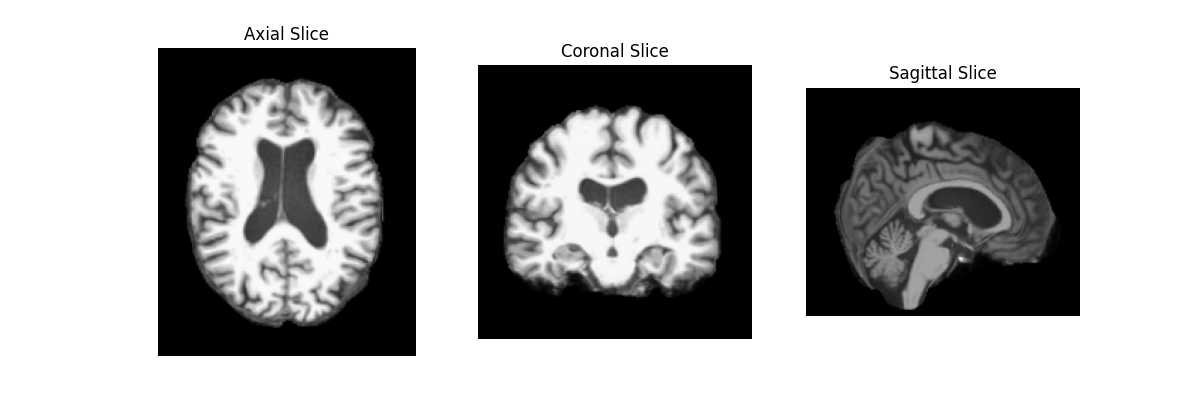

In [11]:
# Extract the middle slices for axial, coronal, and sagittal views
middle_axial_index = mri_data.shape[2] // 2
middle_coronal_index = mri_data.shape[1] // 2
middle_sagittal_index = mri_data.shape[0] // 2

axial_slice = mri_data[:, :, middle_axial_index]
coronal_slice = mri_data[:, middle_coronal_index, :]
sagittal_slice = mri_data[middle_sagittal_index, :, :]

# Visualize the slices
plt.figure(figsize=(12, 4))

# Axial slice
plt.subplot(1, 3, 1)
plt.imshow(axial_slice.T, cmap="gray", origin="lower")
plt.title("Axial Slice")
plt.axis("off")

# Coronal slice
plt.subplot(1, 3, 2)
plt.imshow(coronal_slice.T, cmap="gray", origin="lower")
plt.title("Coronal Slice")
plt.axis("off")

# Sagittal slice
plt.subplot(1, 3, 3)
plt.imshow(sagittal_slice.T, cmap="gray", origin="lower")
plt.title("Sagittal Slice")
plt.axis("off")

plt.show()

In [1]:
# In a new cell
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
import torch.nn.functional as F # For Global Average Pooling

# Ensure pandas is installed in the kernel environment
# You might need to run this once if you haven't already:
# !pip install pandas

# Define paths
FEATURE_ROOT = Path("/data/kuang/Projects/MedSAM/data/BrainAGE_preprocessed")
CSV_PATH = Path("/data/kuang/Projects/MedSAM/data/Subject_demographics_info_brain_age.csv")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
print(f"Feature root: {FEATURE_ROOT}")
print(f"CSV path: {CSV_PATH}")


Using device: cuda
Feature root: /data/kuang/Projects/MedSAM/data/BrainAGE_preprocessed
CSV path: /data/kuang/Projects/MedSAM/data/Subject_demographics_info_brain_age.csv


In [2]:
class AgePredictionDataset(Dataset):
    def __init__(self, npy_dir, csv_path):
        """
        Args:
            npy_dir (str or Path): Directory containing the .npy feature files.
            csv_path (str or Path): Path to the CSV file with metadata.
        """
        self.npy_dir = Path(npy_dir)
        csv_path = Path(csv_path)

        print(f"Loading dataset from NPY dir: {self.npy_dir}")
        print(f"Loading metadata from CSV: {csv_path}")

        # Check if directories/files exist
        if not self.npy_dir.is_dir():
            raise FileNotFoundError(f"NPY directory not found: {self.npy_dir}")
        if not csv_path.is_file():
            raise FileNotFoundError(f"CSV file not found: {csv_path}")

        # Load CSV and build filename -> age lookup
        try:
            df = pd.read_csv(csv_path)
            # The key in the dictionary will be the original filename (e.g., 'ADNI_..._tl.nii.gz')
            self.meta_dict = df.set_index('filename')['age'].to_dict()
            print(f"Loaded metadata for {len(self.meta_dict)} subjects from CSV.")
        except Exception as e:
            raise ValueError(f"Error loading or processing CSV {csv_path}: {e}")

        # Find all .npy files and filter based on metadata
        all_npy_files = list(self.npy_dir.glob("*.npy"))
        self.valid_files = []
        missing_meta_count = 0
        for npy_file in all_npy_files:
            # The key is the npy filename without the trailing '.npy'
            original_filename_key = npy_file.name[:-4]
            if original_filename_key in self.meta_dict:
                self.valid_files.append(npy_file)
            else:
                missing_meta_count += 1

        if missing_meta_count > 0:
            print(f"Warning: {missing_meta_count} .npy files did not have corresponding metadata in the CSV.")

        if not self.valid_files:
             raise RuntimeError(f"No valid .npy files found in {self.npy_dir} that match the metadata.")

        print(f"Found {len(self.valid_files)} valid .npy files with metadata.")


    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        npy_path = self.valid_files[idx]
        original_filename_key = npy_path.name[:-4] # Key for metadata dict

        # Load the embedding
        try:
            # Shape is likely (1, 256, 64, 64)
            embedding = np.load(npy_path)
            embedding_tensor = torch.tensor(embedding, dtype=torch.float32)

            # Apply Global Average Pooling (GAP)
            # Input shape: (1, 256, 64, 64)
            # Output shape after avg_pool2d: (1, 256, 1, 1)
            # Output shape after squeeze: (256,)
            if embedding_tensor.shape == (1, 256, 64, 64):
                 pooled_embedding = F.adaptive_avg_pool2d(embedding_tensor, (1, 1)).squeeze()
            else:
                 # Handle cases where it might already be pooled or has unexpected shape
                 print(f"Warning: Unexpected embedding shape {embedding_tensor.shape} for {npy_path}. Trying to squeeze.")
                 pooled_embedding = embedding_tensor.squeeze()
                 if pooled_embedding.shape[0] != 256:
                      raise ValueError(f"Embedding shape after squeeze is not 256 for {npy_path}: {pooled_embedding.shape}")


            # Get the age
            age = self.meta_dict[original_filename_key]
            age_tensor = torch.tensor(age, dtype=torch.float32)

            return pooled_embedding, age_tensor

        except Exception as e:
            print(f"Error loading or processing file {npy_path}: {e}")
            # Return dummy data or raise error, depending on desired behavior
            # Returning dummy data might hide issues
            # return torch.zeros(256, dtype=torch.float32), torch.tensor(0.0, dtype=torch.float32)
            raise e # Re-raise the exception to stop if errors occur

In [3]:
class AgeMLP(nn.Module):
    def __init__(self, input_dim=256, hidden_dim1=128, hidden_dim2=64):
        super(AgeMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.3), # Add dropout for regularization
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim2, 1) # Output is a single value (age)
        )

    def forward(self, x):
        # Input x shape: (batch_size, input_dim)
        # Output shape: (batch_size, 1)
        output = self.mlp(x)
        # Squeeze the last dimension to get shape (batch_size,)
        return output.squeeze(-1)


In [12]:
import torch
import torch.nn as nn

class AgeMLPWithAttentionBN(nn.Module):
    def __init__(self, input_dim=256, embed_dim=256, num_heads=8,
                 hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        """
        MLP for age prediction with input self-attention and batch normalization.

        Args:
            input_dim (int): Dimension of the input feature vector after GAP (e.g., 256).
            embed_dim (int): Embedding dimension for the attention mechanism (must be divisible by num_heads).
                               Usually same as input_dim.
            num_heads (int): Number of attention heads.
            hidden_dim1 (int): Size of the first hidden layer.
            hidden_dim2 (int): Size of the second hidden layer.
            hidden_dim3 (int): Size of the third hidden layer (newly added).
            dropout_rate (float): Dropout probability.
        """
        super(AgeMLPWithAttentionBN, self).__init__()

        if embed_dim % num_heads != 0:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})")

        # Self-Attention Layer for input features
        # Input: (batch_size, input_dim) -> Reshape to (1, batch_size, input_dim) for attention
        # Output: (1, batch_size, input_dim) -> Squeeze back to (batch_size, input_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=False) # batch_first=False expects (SeqLen, Batch, Dim)
        self.norm_attn = nn.LayerNorm(embed_dim) # Layer norm after attention

        # MLP layers with Batch Normalization and Dropout
        self.mlp = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Layer 2
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Layer 3 (New)
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.BatchNorm1d(hidden_dim3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Output Layer
            nn.Linear(hidden_dim3, 1) # Output is a single value (age)
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)

        # --- Apply Self-Attention ---
        # Reshape for MultiheadAttention: (batch_size, input_dim) -> (1, batch_size, input_dim)
        # Assuming sequence length is 1 for the flattened feature vector
        x_attn = x.unsqueeze(0)

        # MultiheadAttention expects query, key, value
        attn_output, _ = self.attention(x_attn, x_attn, x_attn)

        # Add & Norm (Residual connection + Layer Normalization)
        x = self.norm_attn(x_attn + attn_output) # Add residual connection

        # Squeeze back: (1, batch_size, input_dim) -> (batch_size, input_dim)
        x = x.squeeze(0)
        # --- Attention End ---


        # --- Pass through MLP ---
        # Input x shape: (batch_size, input_dim)
        # Output shape: (batch_size, 1)
        output = self.mlp(x)

        # Squeeze the last dimension to get shape (batch_size,)
        return output.squeeze(-1)


In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train() # Set model to training mode
    total_loss = 0.0
    num_samples = 0
    for features, ages in loader:
        features, ages = features.to(device), ages.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(features)

        # Calculate loss
        loss = criterion(predictions, ages)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * features.size(0)
        num_samples += features.size(0)

    return total_loss / num_samples

@torch.no_grad() # Disable gradient calculations for evaluation
def evaluate(model, loader, criterion, device):
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    total_mae = 0.0
    num_samples = 0
    for features, ages in loader:
        features, ages = features.to(device), ages.to(device)

        # Forward pass
        predictions = model(features)

        # Calculate loss (e.g., MSE)
        loss = criterion(predictions, ages)
        total_loss += loss.item() * features.size(0)

        # Calculate MAE
        mae = torch.abs(predictions - ages).mean()
        total_mae += mae.item() * features.size(0)

        num_samples += features.size(0)

    avg_loss = total_loss / num_samples
    avg_mae = total_mae / num_samples
    return avg_loss, avg_mae

In [15]:
# --- Hyperparameters ---
EPOCHS = 1000 # Increased total epochs
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
WEIGHT_DECAY = 1e-5
SCHEDULER_PATIENCE_PERCENT = 0.10 # e.g., 10% for LR scheduler
EARLY_STOPPING_PATIENCE = 40 # Number of epochs to wait for val_mae improvement
# ---

# --- Setup ---
# Instantiate Datasets
try:
    train_dataset = AgePredictionDataset(npy_dir=FEATURE_ROOT / 'train', csv_path=CSV_PATH)
    val_dataset = AgePredictionDataset(npy_dir=FEATURE_ROOT / 'validation', csv_path=CSV_PATH)
    # test_dataset = AgePredictionDataset(npy_dir=FEATURE_ROOT / 'test', csv_path=CSV_PATH) # Optional: for final testing
except (FileNotFoundError, ValueError, RuntimeError) as e:
    print(f"Error initializing datasets: {e}")
    # Stop execution if datasets fail to load
    raise SystemExit("Dataset loading failed.")


# Instantiate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True) # Optional

# Instantiate Model, Loss, Optimizer
# model = AgeMLP().to(DEVICE)
# criterion = nn.MSELoss() # Mean Squared Error Loss for regression
model = AgeMLPWithAttentionBN(input_dim=256, embed_dim=256, num_heads=8, # Use the new model
                              hidden_dim1=128, hidden_dim2=64, hidden_dim3=32,
                              dropout_rate=0.3).to(DEVICE)
criterion = nn.L1Loss() # Or Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Calculate scheduler patience based on percentage
scheduler_patience_epochs = max(1, int(EPOCHS * SCHEDULER_PATIENCE_PERCENT))
print(f"Using ReduceLROnPlateau patience: {scheduler_patience_epochs} epochs")
print(f"Using Early Stopping patience: {EARLY_STOPPING_PATIENCE} epochs")

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=scheduler_patience_epochs, factor=0.5, verbose=True) # Learning rate scheduler

print("\n--- Starting Training ---")

# --- Initialization for Tracking and Early Stopping ---
best_val_mae = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_mae': []}
best_epoch = 0 # Keep track of the epoch with the best MAE

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_mae = evaluate(model, val_loader, criterion, DEVICE)

    # Store metrics for plotting
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.2f}")

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # --- Early Stopping Check ---
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        epochs_no_improve = 0 # Reset counter
        best_epoch = epoch + 1
        # Save the best model weights
        torch.save(model.state_dict(), "best_age_mlp_model.pth")
        print(f"  -> New best Val MAE: {best_val_mae:.2f}. Saved model to best_age_mlp_model.pth")
    else:
        epochs_no_improve += 1
        print(f"  -> Val MAE did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {EARLY_STOPPING_PATIENCE} epochs without improvement.")
        print(f"Best Validation MAE: {best_val_mae:.2f} achieved at epoch {best_epoch}")
        break # Exit the training loop

# --- Training Finished ---
# Check if loop finished naturally or broke early
if epoch == EPOCHS - 1:
    print("\n--- Training Finished (Reached Max Epochs) ---")
else:
     print("\n--- Training Finished (Early Stopping) ---")

print(f"Best Validation MAE achieved: {best_val_mae:.2f} at epoch {best_epoch}")



Loading dataset from NPY dir: /data/kuang/Projects/MedSAM/data/BrainAGE_preprocessed/train
Loading metadata from CSV: /data/kuang/Projects/MedSAM/data/Subject_demographics_info_brain_age.csv
Loaded metadata for 2850 subjects from CSV.
Found 2274 valid .npy files with metadata.
Loading dataset from NPY dir: /data/kuang/Projects/MedSAM/data/BrainAGE_preprocessed/validation
Loading metadata from CSV: /data/kuang/Projects/MedSAM/data/Subject_demographics_info_brain_age.csv
Loaded metadata for 2850 subjects from CSV.
Found 280 valid .npy files with metadata.
Using ReduceLROnPlateau patience: 100 epochs
Using Early Stopping patience: 40 epochs

--- Starting Training ---
Epoch 1/1000 | Train Loss: 54.2239 | Val Loss: 53.4042 | Val MAE: 53.40
  -> New best Val MAE: 53.40. Saved model to best_age_mlp_model.pth
Epoch 2/1000 | Train Loss: 53.9878 | Val Loss: 53.3665 | Val MAE: 53.37
  -> New best Val MAE: 53.37. Saved model to best_age_mlp_model.pth
Epoch 3/1000 | Train Loss: 53.7573 | Val Loss: 

In [16]:

print("\n--- Evaluating on Test Set using Best Model ---")
try:
    # Make sure test_dataset and test_loader are defined if you uncomment this
    test_dataset = AgePredictionDataset(npy_dir=FEATURE_ROOT / 'test', csv_path=CSV_PATH)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
  # Load the weights from the best epoch
    model.load_state_dict(torch.load("best_age_mlp_model.pth"))
    print("Loaded best model weights for testing.")

    test_loss, test_mae = evaluate(model, test_loader, criterion, DEVICE)
    print(f"Test Loss: {test_loss:.4f} | Test MAE: {test_mae:.2f}")
except FileNotFoundError:
    print("Could not find 'best_age_mlp_model.pth'. Skipping test set evaluation.")
except NameError:
     print("Test dataset/loader not defined. Skipping test set evaluation.")
except Exception as e:
     print(f"Error during test set evaluation: {e}")



--- Evaluating on Test Set using Best Model ---
Loading dataset from NPY dir: /data/kuang/Projects/MedSAM/data/BrainAGE_preprocessed/test
Loading metadata from CSV: /data/kuang/Projects/MedSAM/data/Subject_demographics_info_brain_age.csv
Loaded metadata for 2850 subjects from CSV.
Found 296 valid .npy files with metadata.
Loaded best model weights for testing.


Test Loss: 7.4408 | Test MAE: 7.44


In [33]:
import random

# Select a random sample from the test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
random_sample, ground_truth_age = test_dataset[random_idx]

# Ensure the sample is on the correct device
random_sample = random_sample.to(DEVICE)
filename_without_extension = test_dataset.valid_files[random_idx].stem
print(f"Filename (without .npy): {filename_without_extension}")

# Load the best model weights
model.load_state_dict(torch.load("best_age_mlp_model_mlp3attnb16.pth"))
model.eval()  # Set the model to evaluation mode

# Predict the brain age
with torch.no_grad():
    predicted_age = model(random_sample.unsqueeze(0)).item()  # Add batch dimension

# Print the ground truth and prediction
print(f"Ground Truth Age: {ground_truth_age:.2f}")
print(f"Predicted Age: {predicted_age:.2f}")

Filename (without .npy): IXI338-HH-1971-T1_mri_brainmask_mni152brain_affine_tl.nii.gz
Ground Truth Age: 61.49
Predicted Age: 62.06
